# Chapter 8: The autoregressive moving average (ARMA) model



### 8.1. Time series basics
> ###### 8.1.1. Trend, cycle, seasonality
> ###### 8.1.2.  Log prices properties
> ###### 8.1.3. The linear regression
### 8.2. AR and MA models
> ###### 8.2.1. Autoregressor model (AR)
> ###### 8.2.2. Moving average model (MA)
### 8.3. ARMAs models
> ###### 8.3.1. ARMA model
> ###### 8.3.2. ARIMA model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from Backtest import *

### 8.1.1. Trend, cycle, seasonality

[*********************100%***********************]  1 of 1 completed


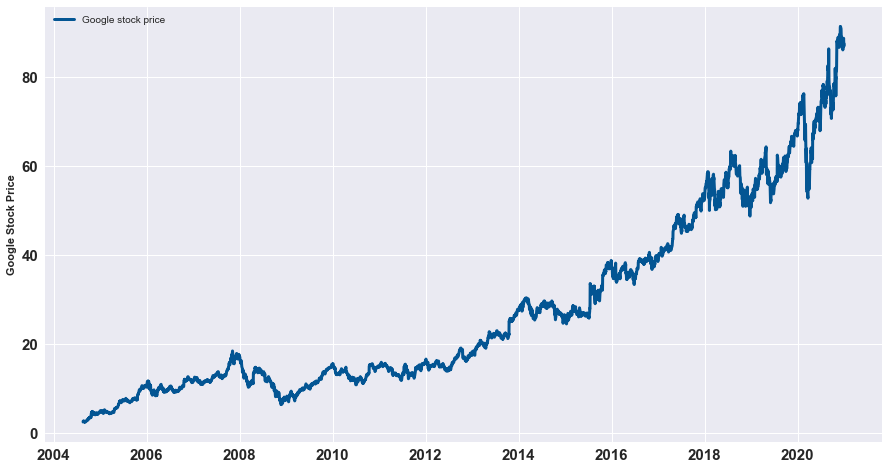

In [2]:
# TRENDING TIME SERIES 
# Import google stock price data
goog = yf.download("GOOG",end="2021-01-01")



# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(goog["Close"], color="#035593", linewidth=3)
plt.ylabel("Google Stock Price",fontweight="bold")
plt.legend(["Google stock price"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

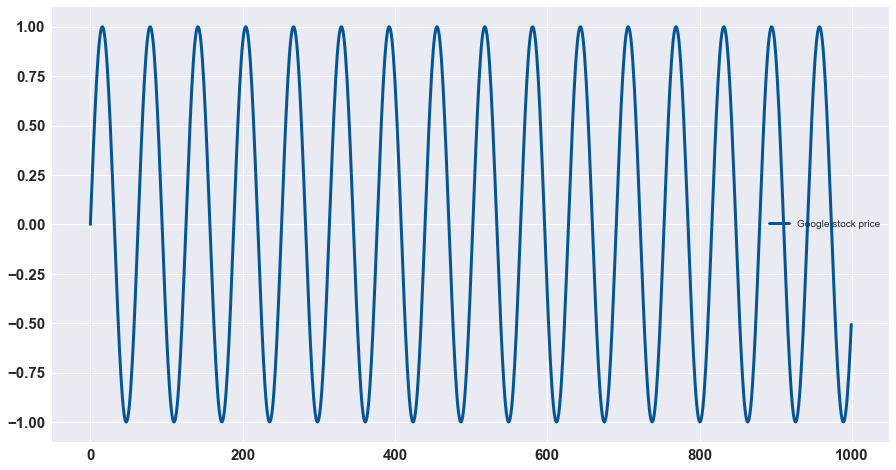

In [3]:
# SEASONAL TIME SERIES 

# Create the data
lin = np.linspace(0,100,1000)
sin = np.sin(lin)


# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(sin, color="#035593", linewidth=3)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.legend(["Google stock price"])
plt.show()

### 8.1.2. Log price properties

Before going deeper, we need to learn some log price properties. We
sometimes use the log price because it allows us to understand the
return variation better.

However,
the price of a stock is an absolute value, and it does not highlight the
relative evolution of the stock.

In [4]:
# Import the data
df = yf.download("GOOG", end="2021-01-01")["Adj Close"]

[*********************100%***********************]  1 of 1 completed


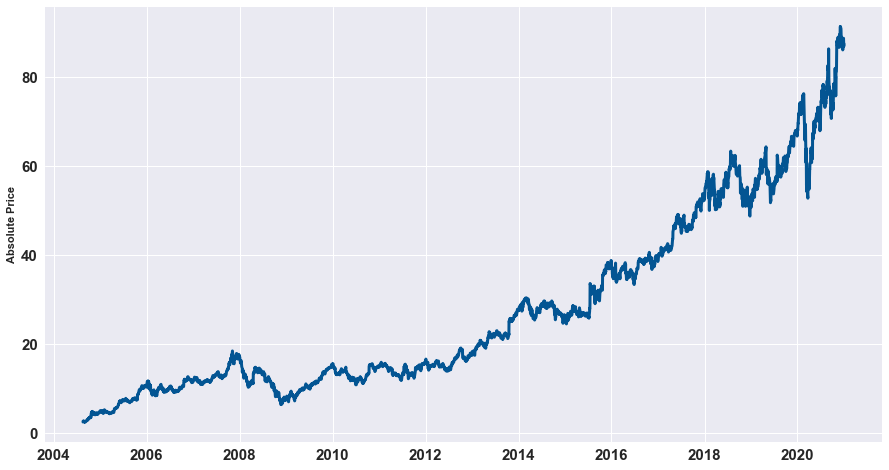

In [5]:
plt.figure(figsize=(15,8))
plt.plot(df, color="#035593", linewidth=3)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.ylabel("Absolute Price",fontweight="bold")
plt.show()

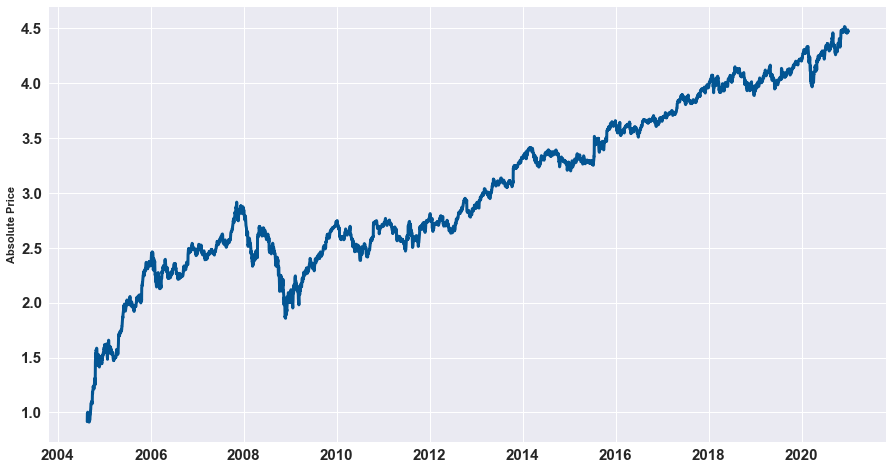

In [6]:
# Plot log price
plt.figure(figsize=(15,8))
plt.plot(np.log(df), color="#035593", linewidth=3)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.ylabel("Absolute Price",fontweight="bold")
plt.show()

Linear regression is a predictive algorithm. The goal of this algorithm
is to allow us to predict some data. For example, suppose we know
the relationship between gold and S&P 500. We can use linear
regression to predict the S&P 500 stock price using the gold price.

### 8.2.1. Autoregressive model (AR)
<br>
Reminder: Now, we work with the EURUSD currency not anymore with Google

It is
a linear regression but uses the previous value of the stock to predict
the value of today or tomorrow.

In [9]:
# Import EURUSD data

# Compute p value on the absolute values
df = yf.download("EURUSD=X", start = "2017-01-10",end="2021-01-10")[["Adj Close"]].dropna()
print("P-value absolute values:",np.round(adfuller(df["Adj Close"])[1],3))

# Compute p values on the variation percentage values
df = df.pct_change(1).dropna()
print("P-value absolute values:",np.round(adfuller(df["Adj Close"])[1],3))

[*********************100%***********************]  1 of 1 completed
P-value absolute values: 0.397
P-value absolute values: 0.0


In [10]:
def AR_predict_value(train_set):
    """ Function for predict the value of tomorrow using AR model"""

    # Define model
    p = 1
    model = ARIMA(train_set, order=(p, 0, 0))

    # Fit the model
    model_fit = model.fit(disp=0)

    # Make forecast
    forecast = model_fit.forecast()

    return forecast[0][0]


def AR(df,returns=True):
    """ Function to predict the test set with a AR model """

    # Find the split
    split = int(len(df)*0.70)

    # Predict the price using AR function
    df['predicted_value'] = df['Adj Close'].rolling(split).apply(AR_predict_value)

    # Compute the returns of the asset
    if returns:
        df['returns'] = df['Adj Close']
        df['signal'] = np.where(df.predicted_value > 0, 1, -1)
    else:
        df['returns'] = df['Adj Close'].pct_change(1)
        df['signal'] = np.where(df.predicted_value > df['Adj Close'], 1, -1)

    df['strategy'] = df.signal.shift(1) * df.returns

    return df

We can answer why doing an AR model with the returns is better
than the price. The answer needs some skills from the previous
chapter. Indeed, it is better to work with stock return than stock price
because we need stationary data (confer section 7.1).

Usually, with AR or ARMA model, we use the differencing methods
to transform the data (pt - pt-1). Still, it is difficult for us to use this
data because, in finance, we do not just want to predict a value, we
want to create a strategy with this value, and we need the percentage
of variation to compute the strategy returns.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.02 	 Alpha: -0.27 %	     Sharpe: -0.076 	 Sortino: -0.115
  -----------------------------------------------------------------------------
    VaR: 15.18 %	 cVaR: 17.38 % 	     VaR/cVaR: 1.145 	 drawdown: 8.47 %
  -----------------------------------------------------------------------------


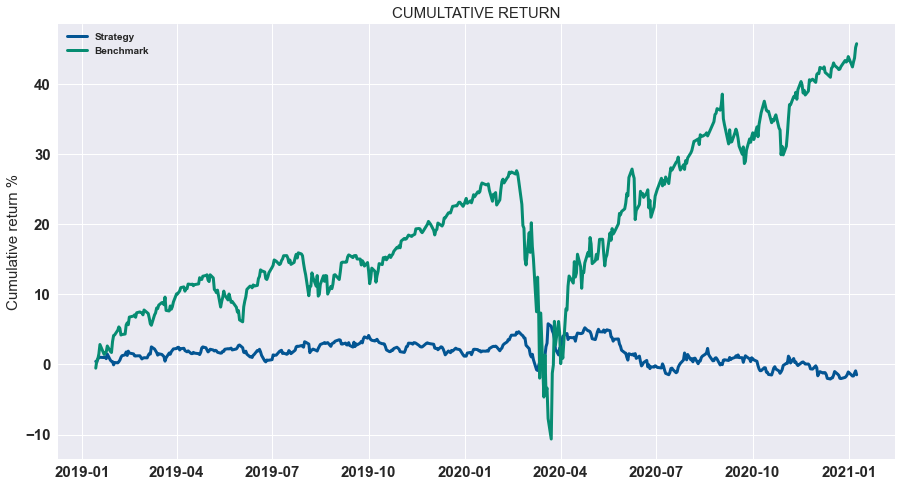

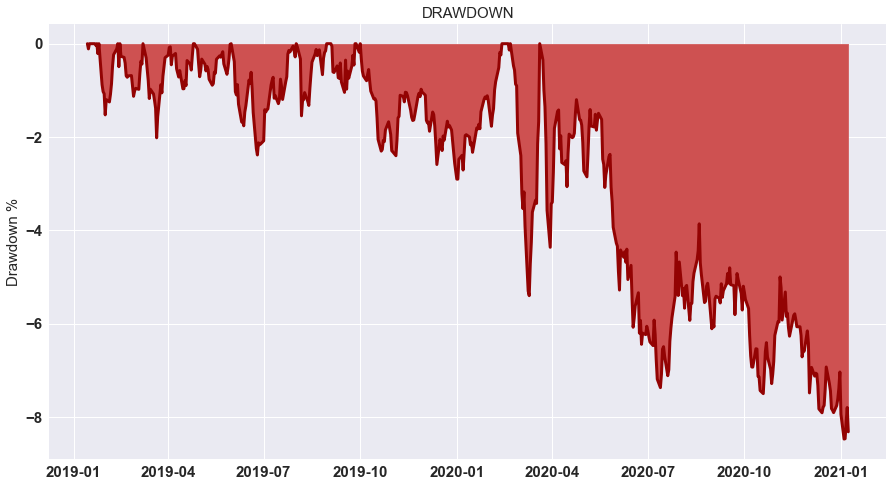

In [11]:
# Import the data
data = yf.download("EURUSD=X",start = "2019-01-10", end="2021-01-10")[["Adj Close"]].pct_change(1).dropna()

# Create the strategy
df = AR(data, returns=True)

# Backtesting
backtest_dynamic_portfolio(df["strategy"])

There
exist many ways to find the best value for p. The first is to try the
model's error using MSE or MAE (confer section 1.1) for p from 1 to
15, for example, and choose the lowest error.

The other way is to use a partial autocorrelation graph to find the best
theoretical number of lags. Nevertheless, what is partial
autocorrelation? A partial autocorrelation summarizes the
relationship between an observation in a time series with previous
observations with the relationships of intervening observations
removed.

We see the autocorrelation graph of the EURUSD returns. The blue
area is the interval in which the partial autocorrelation is not
significant, which means that all the lag greater or lower than the
blue is significant. Thus, we can see that lag 1, 6, and 8 are
significant and have better results. We must choose an AR(8) to
estimate the EURUSD model theoretically.


In finance, we always lag slightly to avoid overfitting
the algorithm. A maximal lag of 3 can be a good idea
because if we take several lags, for example, 150, the
model will be perfect on the train data and not useable
on the test set. We need a model to predict the value of
a test set

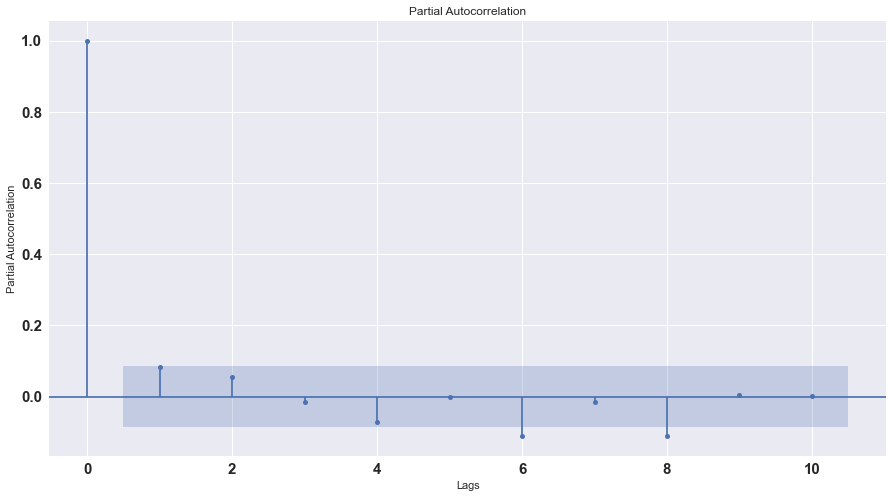

In [12]:
# Plot partial autocorrelation
fig, ax = plt.subplots(figsize=(15, 8))
plot_pacf(df['Adj Close'], lags=10, ax=ax)
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 7.2.2. Moving average model (MA)

Now let us talk about the moving average model. This model will not
use the moving average as the name but the past error of the model. It
is an essential part of the ARMA model because it allows us to learn
not from the value of the train set but from the algorithm's error.

In [12]:
def MA_predict_value(train_set):
    """ Function for predict the value of tomorrow using AR model"""

    # Define model
    q = 1
    model = ARIMA(train_set, order=(0, 0, q))

    # Fit the model
    model_fit = model.fit(disp=0)

    # Make forecast
    forecast = model_fit.forecast()

    return forecast[0][0]

  
def MA(df, returns=True):
    """ Function to predict the test set with a MA model """

    # Find the split
    split = int(len(df)*0.70)

    # Predict the price using AR function
    df['predicted_value'] = df['Adj Close'].rolling(split).apply(MA_predict_value)

    # Compute the returns of the asset
    if returns:
        df['returns'] = df['Adj Close']
        df['signal'] = np.where(df.predicted_value > 0, 1, -1)
    else:
        df['returns'] = df['Adj Close'].pct_change(1)
        df['signal'] = np.where(df.predicted_value > df['Adj Close'], 1, -1)

    df['strategy'] = df.signal.shift(1) * df.returns

    return df

How to choose the q? We can also use the technique which tests all
the q from 1 to 20 to see which has the lowest error on the train set.
Alternatively, we can choose the same method as partial
autocorrelation but using absolute autocorrelation. Let us see the
autocorrelation graph of the EURUSD returns in figure 8.8

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.025 	 Alpha: -0.03 %	     Sharpe: 0.023 	 Sortino: 0.035
  -----------------------------------------------------------------------------
    VaR: 14.74 %	 cVaR: 16.83 % 	     VaR/cVaR: 1.142 	 drawdown: 9.04 %
  -----------------------------------------------------------------------------


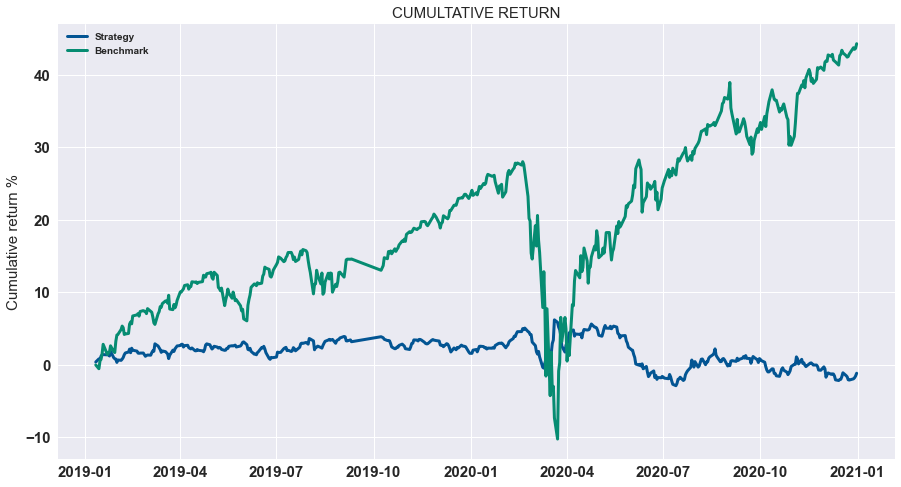

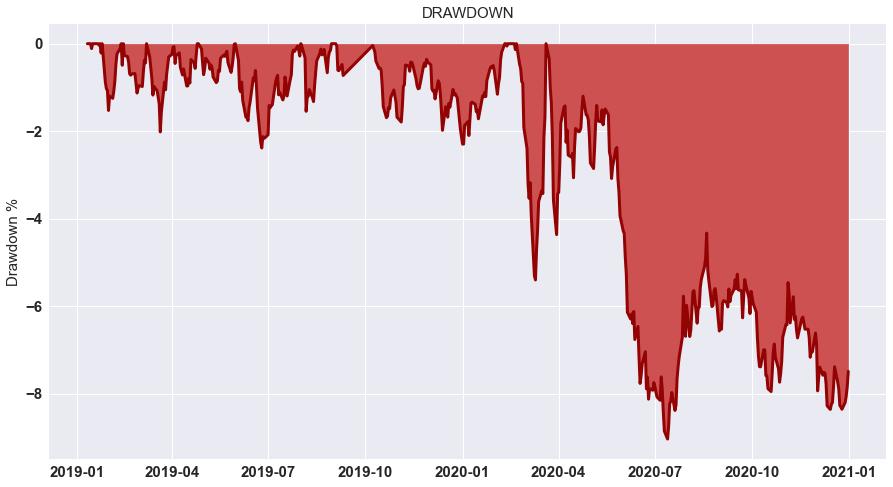

In [13]:
# Import the data
data = yf.download("EURUSD=X",start = "2019-01-10", end="2021-01-01")[["Adj Close"]].pct_change(1).dropna()

# Create the strategy
df = MA(data, returns=True)

# Backtesting
backtest_dynamic_portfolio(df["strategy"])

The alpha, Sharpe, and Sortino ratios are positive. However, as for the
previous strategy, the strategy does not work anymore after the corona
crisis. The excellent point is that the cVaR is equal to 16%, so we should
not lose more than 16% in one year.

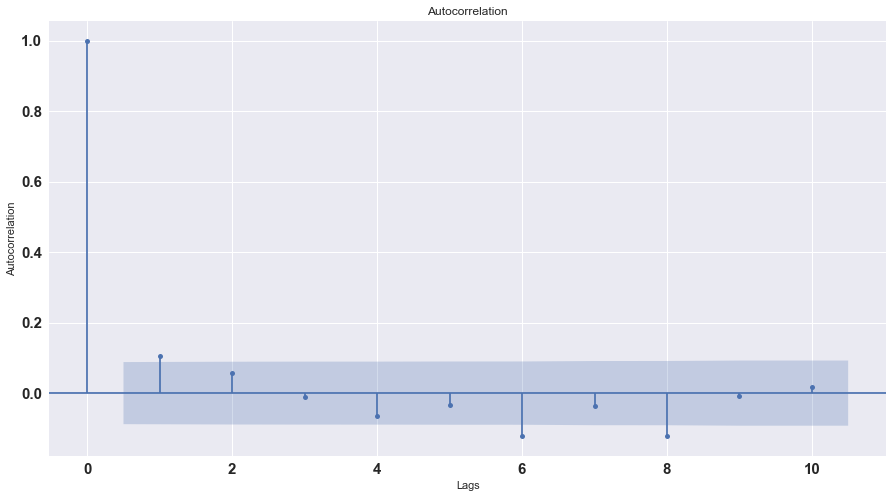

In [14]:
# Plot the autocorrelation
fig, ax = plt.subplots(figsize=(15,8))
plot_acf(df['Adj Close'], lags=10, ax=ax)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

When there is no significant partial autocorrelation or
autocorrelation, it is advised not to use an AR or MA
model. Indeed, sometimes doing nothing is the best
action.

### 8.3.1. ARMA (stationary data needed)

In [13]:
def ARMA_predict_value(train_set):
    """ Function for predict the value of tomorrow using AR model"""

    # Define model
    p = 1
    q = 1
    model = ARIMA(train_set, order=(p, 0, q))

    # Fit the model
    model_fit = model.fit(disp=0)

    # Make forecast
    forecast = model_fit.forecast()

    return forecast[0][0]

  
def ARMA(df,returns=True):
    """ Function to predict the test set with a ARMA model """

    # Find the split
    split = int(len(df)*0.70)

    # Predict the price using AR function
    df['predicted_value'] = df['Adj Close'].rolling(split).apply(ARMA_predict_value)

    # Shift the predicted price by 1 period
    df['predicted_value'] = df['predicted_value'].shift(1)

    # Compute the returns of the asset
    if returns:
        df['returns'] = df['Adj Close']
        df['signal'] = np.where(df.predicted_value > 0, 1, -1)
    else:
        df['returns'] = df['Adj Close'].pct_change(1)
        df['signal'] = np.where(df.predicted_value > df['Adj Close'], 1, -1)

    df['strategy'] = df.signal.shift(1) * df.returns

    return df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.024 	 Alpha: 0.9 %	     Sharpe: 0.1 	 Sortino: 0.151
  -----------------------------------------------------------------------------
    VaR: 14.05 %	 cVaR: 16.21 % 	     VaR/cVaR: 1.154 	 drawdown: 11.13 %
  -----------------------------------------------------------------------------


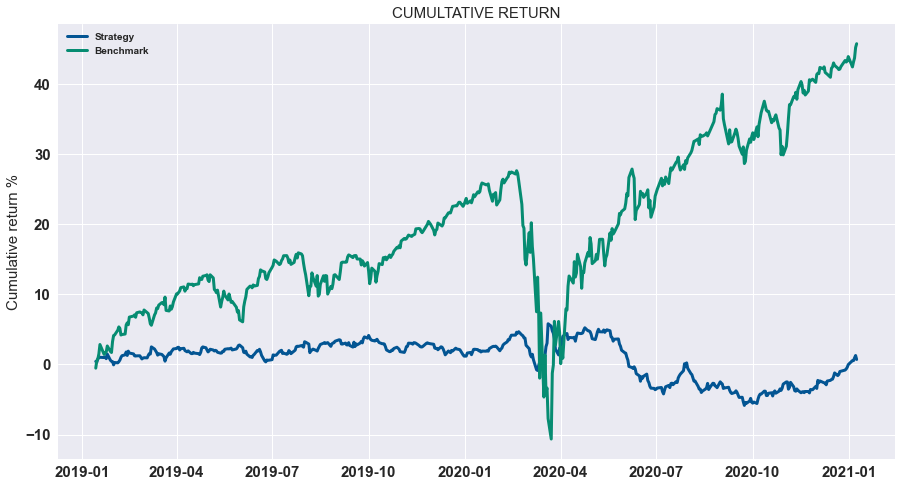

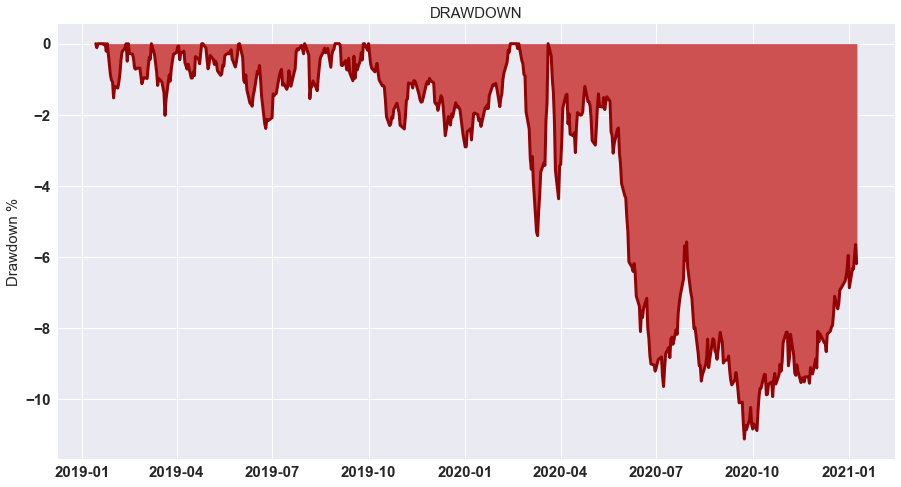

In [14]:
# Import the data
data = yf.download("EURUSD=X",start = "2019-01-10", end="2021-01-10")[["Adj Close"]].pct_change(1).dropna()

# Create the strategy
df = ARMA(data, returns=True)

# Backtesting
backtest_dynamic_portfolio(df["strategy"])

However, in finance, most of the time, series is not stationary. So, we
need to transform the data into a stationary time series. To do it, we
use differencing.

In [15]:
def ARIMA_predict_value(train_set):
    """ Function for predict the value of tomorrow using AR model"""

    # Define model
    p = 1
    q = 1
    d = 1
    model = ARIMA(train_set, order=(p, d, q))

    # Fit the model
    model_fit = model.fit(disp=0)

    # Make forecast
    forecast = model_fit.forecast()

    return forecast[0][0]

  
def ARIMA_model(df,returns=True):
    """ Function to predict the test set ith a ARIMA model """

    # Find the split
    split = int(len(df)*0.70)

    # Predict the price using AR function
    df['predicted_value'] = df['Adj Close'].rolling(split).apply(ARIMA_predict_value)

    # Shift the predicted price by 1 period
    df['predicted_value'] = df['predicted_value'].shift(1)

    # Compute the returns of the asset
    if returns:
        df['returns'] = df['Adj Close']
        df['signal'] = np.where(df.predicted_value > 0, 1, -1)
    else:
        df['returns'] = df['Adj Close'].pct_change(1)
        df['signal'] = np.where(df.predicted_value > df['Adj Close'], 1, -1)

    df['strategy'] = df.signal.shift(1) * df.returns

    return df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.015 	 Alpha: 0.28 %	     Sharpe: 0.183 	 Sortino: 0.286
  -----------------------------------------------------------------------------
    VaR: 13.65 %	 cVaR: 15.85 % 	     VaR/cVaR: 1.161 	 drawdown: 9.4 %
  -----------------------------------------------------------------------------


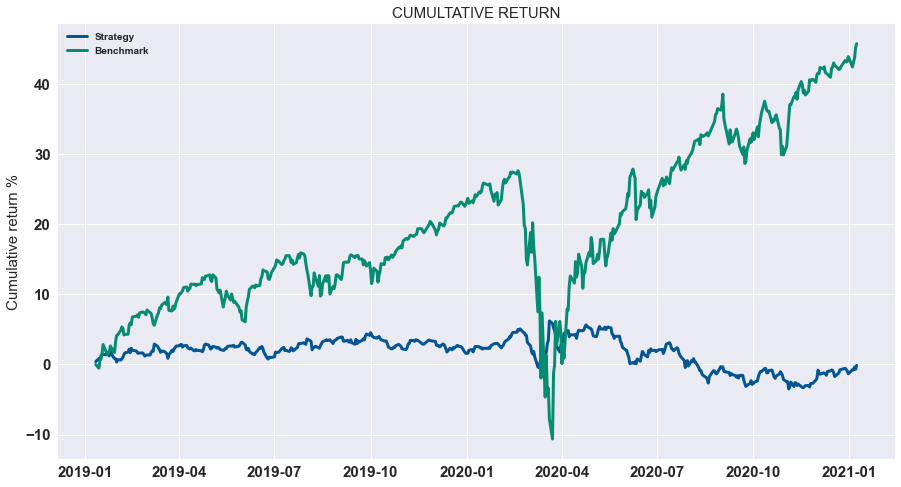

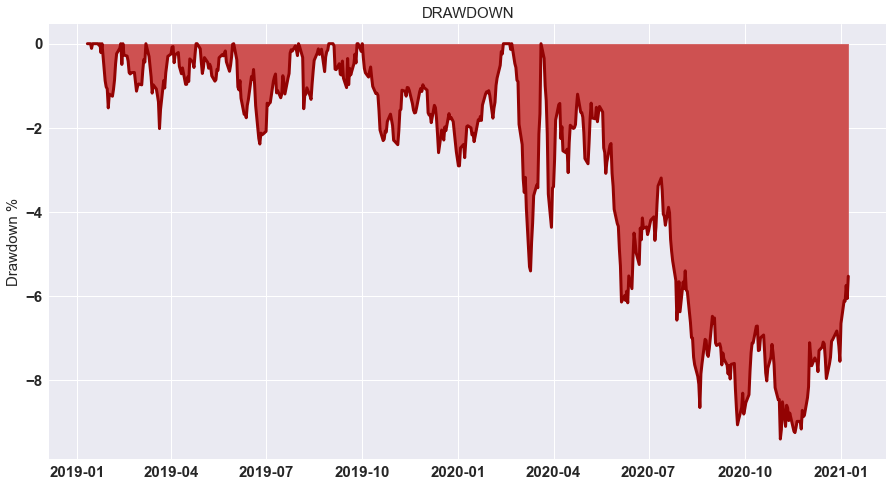

In [17]:
# Import the data
data = yf.download("EURUSD=X",start = "2019-01-10", end="2021-01-10")[["Adj Close"]].dropna()

# Create the strategy
df = ARIMA_model(data, returns=False)

# Backtesting
backtest_dynamic_portfolio(df["strategy"])